In [1]:
# pip install rouge_score
from operator import itemgetter
import pandas as pd
from rouge_score import rouge_scorer

In [2]:
# import corpus_bleu
from nltk.translate.bleu_score import sentence_bleu, corpus_bleu

In [3]:
# Read the validation data
validation_df = pd.read_csv('data/validation.csv')

rouge_scores = []
# Initialize Rouge Scorer                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
scorer = rouge_scorer.RougeScorer(['rougeL'])

# Function that generates summaries using LEAD-N
def lead_summary(text: pd.core.series.Series, titles: pd.core.series.Series, scorer: rouge_scorer.RougeScorer):
    summaries = []
    for idx, row in text.items():
        sentences = row.split(".")
        summaries.append([idx, sentences[0] + "."])
    return summaries

# Function that generates summaries using EXT-ORACLE
def ext_oracle_summary(text: pd.core.series.Series, titles: pd.core.series.Series, scorer: rouge_scorer.RougeScorer):
    summaries = []
    for idx, row in text.items():
        sentences = row.split(".")
        reference = titles.iloc[idx]
        rs = [scorer.score(sentence, reference)['rougeL'][2] for sentence in sentences]
        index, element = max(enumerate(rs), key=itemgetter(1))
        summaries.append([idx, sentences[index]])  
    return summaries
    

In [4]:
lead_summaries = lead_summary(validation_df['text'], validation_df['titles'], scorer)
ext_oracle_summaries = ext_oracle_summary(validation_df['text'], validation_df['titles'], scorer)

lead_rouge = []
ext_oracle_rouge = []
# Calculate the rouge-l score for each of the generated summaries compared to the original titles
for idx, title in validation_df['titles'].items():
    lead_rouge.append(scorer.score(lead_summaries[idx][1], title)['rougeL'][2])
    ext_oracle_rouge.append(scorer.score(ext_oracle_summaries[idx][1], title)['rougeL'][2])

avg_rouge_score_lead = sum(lead_rouge) / len(lead_rouge)
avg_rouge_score_ext_oracle = sum(ext_oracle_rouge) / len(ext_oracle_rouge)

print("Average Rouge-L F-Score with LEAD-1: ", avg_rouge_score_lead)
print("Average Rouge-L F-Score with EXT-ORACLE:", avg_rouge_score_ext_oracle)

# Store the generated summaries in the Kaggle-accepted format
lead_submission_df = pd.DataFrame(lead_summaries, columns=['ID', 'titles'])
ext_oracle_submission_df = pd.DataFrame(ext_oracle_summaries, columns=['ID', 'titles'])
lead_submission_df.to_csv('lead_submission.csv', index=False)
ext_oracle_submission_df.to_csv('ext_oracle_submission.csv', index=False)

Average Rouge-L F-Score with LEAD-1:  0.1535873817959459
Average Rouge-L F-Score with EXT-ORACLE: 0.31354067145919595


For summarization in NLP, especially focusing on title generation, various models and techniques can be employed. Here are some of the prominent ones, along with brief explanations of their use cases:

### 1. Sequence-to-Sequence (Seq2Seq) Models
Seq2Seq models are fundamental in NLP for tasks involving text generation. They work by encoding a source text into a fixed-dimensional context vector and then decoding this vector to produce the output text. For title generation, the input would be the content of an article or document, and the output would be the generated title.

### 2. Attention Mechanisms
Attention mechanisms improve Seq2Seq models by allowing the decoder to focus on different parts of the input sequence during the generation process, improving the relevance of the generated titles to the content.

### 3. Transformer Models
Introduced in the paper "Attention is All You Need" by Vaswani et al., transformers have become the backbone of modern NLP, surpassing Seq2Seq models in performance. They are based entirely on attention mechanisms and are highly effective in generating summaries and titles due to their ability to capture long-range dependencies in text.

### 4. Pre-trained Language Models
Pre-trained models such as GPT (Generative Pre-trained Transformer), BERT (Bidirectional Encoder Representations from Transformers), and their variants (e.g., RoBERTa, T5, BART) can be fine-tuned for the specific task of title generation. These models have been trained on vast amounts of text and have an excellent understanding of language, which makes them highly effective for generating coherent and contextually relevant titles.

#### Fine-tuning Approach:
- **GPT-3 for Direct Generation:** Given a prompt that includes the content, GPT-3 or similar models can directly generate a title based on the given context.
- **T5/BART for Text-to-Text Tasks:** T5 and BART are designed explicitly for text-to-text tasks, such as translation, summarization, and, by extension, title generation. They can be fine-tuned by framing the title generation as a summarization problem where the "summary" is the title of the input text.

### 5. Extractive Summarization Techniques
While not directly designed for title generation, extractive summarization models can identify key phrases or sentences within a text. These key elements can inspire or be directly used in generating titles, especially for academic papers or articles where titles are often descriptive and concise.

When choosing a model for title generation, consider the specific requirements of your task, such as the desired level of creativity, the importance of context preservation, and the available computational resources. Pre-trained models like GPT-3 or T5, due to their versatility and state-of-the-art performance, are often the go-to choice for tasks requiring high-quality text generation, including title generation.

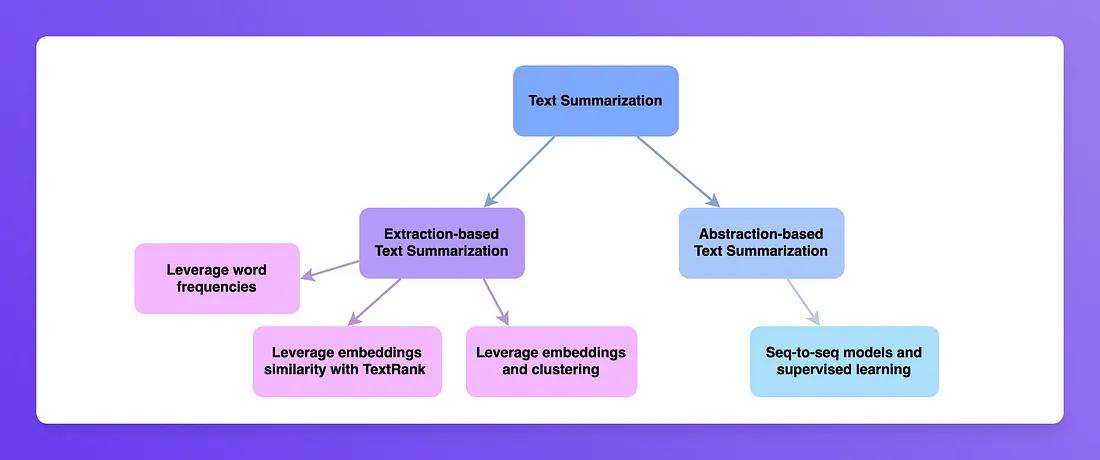

**Extraction-based summarization:** a subset of words or sentences that represent the most important points is pulled from the long text and combined to make a summary. The results may not be grammatically accurate.

**Abstraction-based summarization:** advanced deep learning techniques (mainly in seq-to-seq models) are applied to paraphrase and shorten the original document, just like humans do. Since abstractive machine learning algorithms can generate new phrases and sentences that represent the most important information from the source text, they can assist in overcoming the grammatical inaccuracies of the extraction-based techniques

#### Extraction-based summarization with word frequencies
This is probably the easiest way to implement an extraction-based summarizer.

Clean the document removing stopwords, numbers, punctuation, and other special characters.
Split the document into sentences.
Count how many times each word appears in the document and divide it by the occurrences of the most frequent word that appears in the document, to obtain word frequencies.
Sum the word frequencies of all the words that appear in the same sentence and obtain a score for each sentence.
Keep the sentence with a score higher than a certain threshold and use them as the summary.

#### Extraction-based summarization with TextRank
This is how the TextRank algorithm works:

Split the document into sentences.
Get a sentence embedding for each sentence.
Build a graph where nodes are the sentences and edge weights are the similarities (e.g. cosine similarity) of the sentence embeddings.
Run the PageRank algorithm on the graph to obtain a PageRank score for each sentence. A high PageRank score means that the node is important for the network.
Keep the sentences with a score higher than a certain threshold to use them as the summary of the document.

#### Extraction-based summarization with sentence embeddings and clustering
You can easily use this method with the bert-extractive-summarizer library. See the paper for more in-depth details.

Resolve coreferences in the document (see Coreference Resolution).
Split the document into sentences.
Get a sentence embedding (e.g. using BERT) for each sentence.
Run K-Means on the sentence embeddings and get K clusters. K will be the number of sentences in the summary.
Find the closest sentence to the centroid of each cluster and use them to compose the summary.

#### Abstraction-based summarization with seq-to-seq models : 
https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/

You can leverage pre-trained models from Hugging Face.

Get a dataset with documents paired with summaries, such as the Cornell Newsroom Dataset and the NewSHead Dataset.
Choose a suitable metric for text summarization, such as ROUGE.
Train a seq-to-seq model (usually a Transformer-based model) to produce summaries from texts in a supervised way.

In [31]:
import pandas as pd

data_path = 'data/train.csv'
data_val = 'data/validation.csv'
data_text = 'data/test_text.csv'

# Load the training data
data = pd.read_csv(data_path)

# Load the validation data
data_val = pd.read_csv(data_val)

# Load the test data
data_text = pd.read_csv(data_text)

# Display the first 5 rows of the dataframe
print("training data:......................................................")
print(data.head())

print("validation data:...................................................................")
print(data_val.head())

print("test data:................................................................................................")
print(data_text.head())

training data:......................................................
                                                text  \
0  Thierry Mariani sur la liste du Rassemblement ...   
1  C'est désormais officiel : Alain Juppé n'est p...   
2  La mesure est décriée par les avocats et les m...   
3  Dans une interview accordée au Figaro mercredi...   
4  Le préjudice est estimé à 2 millions d'euros. ...   

                                              titles  
0  L'information n'a pas été confirmée par l'inté...  
1  Le maire de Bordeaux ne fait plus partie des R...  
2  En 2020, les tribunaux d'instance fusionnent a...  
3  Les médecins jugés "gros prescripteurs d'arrêt...  
4  Il aura fallu mobiliser 90 gendarmes pour cett...  
validation data:...................................................................
                                                text  \
0  Sur les réseaux sociaux, les images sont impre...   
1  La vidéo est devenue virale. Elle montre un po...   
2  Depuis la

# 1st Stat method : Extractive text summarization : Extraction-based summarization with word frequencies
As the name suggests, extractive text summarization ‘extracts’ notable information from the large dumps of text provided and groups them into clear and concise summaries.
The method is very straightforward as it extracts texts based on parameters such as the text to be summarized, the most important sentences (Top K), and the value of each of these sentences to the overall subject.
This, however, also means that the method is limited to predetermined parameters that can make extracted text biased under certain conditions.
Owing to its simplicity in most use cases, extractive text summarization is the most common method used by automatic text summarizers.

We give a score to each word based on their frequency of occurrence in the entire corpus(you would want to remove stop words from your text, as they might skew your frequency counts wrongly). Now the sentences in each input article would be scored based on the total sum frequencies of its consisting words.

In [32]:
from nltk.tokenize import word_tokenize,sent_tokenize
import numpy as np 

In [33]:
def count_freq2(df):

    res = {}
    for i in [df]:
        print(len(i))
        for k in word_tokenize(i):
            if k in res:
                res[k] += 1
            else:
                res[k] = 1
    return res

In [36]:
def count_freq(df):
    
    res = {}
    sentences = sent_tokenize(df)
    for sentence in sentences:
        temp = 0
        words = word_tokenize(sentence)
        for k in words:
            if k in res:
                res[k] += 1
            else:
                res[k] = 1
    return res

In [37]:
print(data_text['text'][352])
print(count_freq(data_text['text'][352]))
print(count_freq2(data_text['text'][352]))

Ségolène Royal a vertement répondu, vendredi 24 janvier, à Emmanuel Macron, qui fustigeait les discours politiques qui tentent, selon lui, de justifier la violence."On est dans un régime autoritaire", a assuré Ségolène Royal sur BFMTV. L'ancienne ministre socialiste, révoquée de ses fonctions d'ambassadrice des pôles et qui n'exclut pas de se présenter en 2022, a décrit "un pouvoir qui n'écoute pas, qui n'en fait qu'à sa tête, qui assiste à la souffrance des citoyens sans réagir." "Quand on voit dans le monde entier les images de violence de ce qui se passe en France, dans la rue, il y a beaucoup d'interrogations sur la nature de ce régime en effet", a-t-elle relevé."On attendait de ce Conseil des ministres qu'il retire la réforme des retraites, comme le souhaite plus de 60% des Français , a-t-elle encore dit. Cette réforme a été très mal engagée, de façon autoritaire, autocratique même, puisque les débats parlementaires n'ont même pas commencé. Donc il y a un vrai problème de crise dé

In [43]:
def sentence_rank(text, word_freq):
    weights = []
    sentences = sent_tokenize(text)
    for sentence in sentences:
        temp = 0
        words = word_tokenize(sentence)
        for word in words:
            temp += word_freq[word]
        weights.append(temp)
    return weights

In [44]:
print(data_text['text'][352])
print(sentence_rank(data_text['text'][352], count_freq(data_text['text'][352])))
print(sent_tokenize(data_text['text'][352]))


Ségolène Royal a vertement répondu, vendredi 24 janvier, à Emmanuel Macron, qui fustigeait les discours politiques qui tentent, selon lui, de justifier la violence."On est dans un régime autoritaire", a assuré Ségolène Royal sur BFMTV. L'ancienne ministre socialiste, révoquée de ses fonctions d'ambassadrice des pôles et qui n'exclut pas de se présenter en 2022, a décrit "un pouvoir qui n'écoute pas, qui n'en fait qu'à sa tête, qui assiste à la souffrance des citoyens sans réagir." "Quand on voit dans le monde entier les images de violence de ce qui se passe en France, dans la rue, il y a beaucoup d'interrogations sur la nature de ce régime en effet", a-t-elle relevé."On attendait de ce Conseil des ministres qu'il retire la réforme des retraites, comme le souhaite plus de 60% des Français , a-t-elle encore dit. Cette réforme a été très mal engagée, de façon autoritaire, autocratique même, puisque les débats parlementaires n'ont même pas commencé. Donc il y a un vrai problème de crise dé

In [45]:
ranked_sentences = sentence_rank(data['text'][0], count_freq(data['text'][0]))
print(ranked_sentences)
sentences = sent_tokenize(data['text'][0])
print(sentences)
sort_list = np.argsort(ranked_sentences)[::-1][:14]
print(sort_list)


[64, 72, 129, 27, 40, 130, 58, 121, 114, 162, 72, 53, 47, 29, 80, 178, 80, 85]
['Thierry Mariani sur la liste du Rassemblement national (RN, ex-FN) aux européennes ?', "C'est ce qu'affirme mardi 11 septembre Chez Pol, la nouvelle newsletter politique de Libération.", "L'ancien député Les Républicain et ministre de Nicolas Sarkozy serait sur le point de rejoindre les troupes de Marine Le Pen pour le élections européennes de 2019.", '"Ça va se faire.', "Ce n'est plus qu'une question de calendrier.", 'On n\'est pas obligé de l\'annoncer tout de suite, à huit mois des européennes", aurait ainsi assuré un membre influent du RN.', "Contacté par Franceinfo, M. Mariani n'a pas confirmé l'information.", '"Les élections sont en juin, je ne sais même pas qui sera numéro 1 sur la liste", a répondu l\'ancien ministre des Transports.', 'Il reconnaît toutefois, toujours cité par Franceinfo, que son nom sur la liste du RN "fait partie des possibilités".', '"Fréjus est une ville sympathique mais je n\'

In [81]:
liste = []
for i in range(10):
    ranked_sentences = sentence_rank(data['text'][i], count_freq(data['text'][i]))
    sentences = sent_tokenize(data['text'][i])
    # n = 20% de len de sentences
    n = int(0.2 * len(sentences))
    sort_list = np.argsort(ranked_sentences)[::-1][:n]
    result = ''
    for i in range(n):
        result += '{} '.format(sentences[sort_list[i]])
        
    candidate = result
    reference = data['titles'][i]
    #print(corpus_bleu(reference[:len(candidate)],candidate[:len(reference)]))
    # compute rouge score
    #print(scorer.score(candidate, reference)['rougeL'][2])
    
    # add in a data frame the result the refrence and the bleu and rouge score
    liste.append([candidate, reference, corpus_bleu(reference[:len(candidate)],candidate[:len(reference)]), scorer.score(candidate, reference)['rougeL'][2]])
    
# transform the list to a dataframe
df = pd.DataFrame(liste, columns = ['candidate', 'reference', 'bleu', 'rouge'])

/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contain

In [82]:
df.head()

,candidate,reference,bleu,rouge
0,"Puis, en avril, avait bruissé la rumeur d'un r...","En 2020, les tribunaux d'instance fusionnent a...",1.009223e-231,0.122449
1,"C'est avec tristesse que je l'ai quittée, mais...",Le maire de Bordeaux ne fait plus partie des R...,9.831838e-232,0.123077
2,"Empêtrée dans cette polémique, la ministre s'e...","Les médecins jugés ""gros prescripteurs d'arrêt...",1.013583e-231,0.058577
3,Pointant la disparité des durées d'arrêts mala...,"En 2020, les tribunaux d'instance fusionnent a...",9.842842e-232,0.088106
4,"Face à ""l'ampleur et la complexité de cette es...",L'information n'a pas été confirmée par l'inté...,6.957991e-232,0.071429


In [63]:
data_text = 'data/test_text.csv'

# Load the test data
data_text = pd.read_csv(data_text)
liste = []

for idx, row in data_text['text'].items():
    i = idx
    ranked_sentences = sentence_rank(data_text['text'][i], count_freq(data_text['text'][i]))
    sentences = sent_tokenize(data_text['text'][i])
    # n = 20% de len de sentences
    n = int(0.2 * len(sentences))
    if(n==0): 
        n=1
    sort_list = np.argsort(ranked_sentences)[::-1][:n]
    result = ''

    for i in range(n):
        result += '{} '.format(sentences[sort_list[i]])
        
    candidate = result

    # add in a data frame the result the refrence and the bleu and rouge score
    liste.append([idx ,candidate])
    
# transform the list to a dataframe
df = pd.DataFrame(liste, columns = ['ID','titles'])

In [65]:
df.head()
df.to_csv('freq_submission.csv', index=False)

# Extraction-based summarization with TextRank
This is how the TextRank algorithm works:

Split the document into sentences.
Get a sentence embedding for each sentence.
Build a graph where nodes are the sentences and edge weights are the similarities (e.g. cosine similarity) of the sentence embeddings.
Run the PageRank algorithm on the graph to obtain a PageRank score for each sentence. A high PageRank score means that the node is important for the network.
Keep the sentences with a score higher than a certain threshold to use them as the summary of the document.

In [6]:
#!pip install sentence-transformers networkx numpy
#!pip install --upgrade scipy
#!pip install "networkx<version>"
#!pip install sentence-transformers networkx numpy matplotlib

In [66]:
from sentence_transformers import SentenceTransformer
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import scipy.sparse as sp

import torch

device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

def text_rank_summarization(document, summary_ratio=0.3):
    # Split the document into sentences
    sentences = document.split('. ')  # Simple split, consider using nltk or spacy for better sentence tokenization
    
    print(sentences)
    # Initialize the sentence embedding model
    model = SentenceTransformer('all-MiniLM-L6-v2')
    
    model.to(device)
    
    # Get a sentence embedding for each sentence
    embeddings = model.encode(sentences)
    
    # Calculate cosine similarity between sentence embeddings
    cosine_similarities = cosine_similarity(embeddings)
    
    # Build a graph where nodes are sentences and edge weights are the similarities of sentence embeddings
    graph = nx.from_numpy_array(cosine_similarities)
    
    #print("the sentences are: ", sentences)
    
    # Plot the graph
    """plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(graph)
    nx.draw(graph, pos, with_labels=True, node_size=6000, node_color="skyblue", font_size=0)
    labels = {i: f"Sentence {i+1}" for i in range(len(sentences))}
    nx.draw_networkx_labels(graph, pos, labels, font_size=15)
    plt.title("TextRank Sentence Graph")
    plt.show()"""
    
    
    # =============================================================================
    
    # Run the PageRank algorithm on the graph
    scores = nx.pagerank(graph)
    
    # Sort sentences by PageRank score
    ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(sentences)), reverse=True)
    
    # Determine the number of sentences to include in summary based on the summary_ratio
    num_sentences = int(np.ceil(len(sentences) * summary_ratio))
    
    # Keep the sentences with a score higher than a certain threshold to use them as the summary of the document
    summarized_sentences = [ranked_sentences[i][1] for i in range(num_sentences)]
    
    # Return the summarized text
    return '. '.join(summarized_sentences)

# Example document
document = """Cats are fascinating creatures known for their independent nature and graceful agility. They have been cherished as companions for thousands of years, valued for their hunting prowess and their ability to provide comfort and friendship to their human counterparts. With their varied breeds, each possessing unique patterns and personalities, cats continue to captivate the hearts of pet lovers around the world."""

# Generate summary
summary = text_rank_summarization(document)
print(summary)


c:\Users\Ines\anaconda3\envs\pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cpu
['Cats are fascinating creatures known for their independent nature and graceful agility', 'They have been cherished as companions for thousands of years, valued for their hunting prowess and their ability to provide comfort and friendship to their human counterparts', 'With their varied breeds, each possessing unique patterns and personalities, cats continue to captivate the hearts of pet lovers around the world.']
Cats are fascinating creatures known for their independent nature and graceful agility


In [28]:
from tqdm import tqdm

from nltk.translate.bleu_score import SmoothingFunction

# Create an instance of the SmoothingFunction
chencherry = SmoothingFunction()

# use text rank to summarize data_val['text'][i]
liste = []
for i in tqdm(range(len(data_val['text']))):
    result = text_rank_summarization(data_val['text'][i])
    candidate = result
    reference = data_val['titles'][i]
    # add in a data frame the result the refrence and the bleu and rouge score
    liste.append([candidate, reference, corpus_bleu(reference[:len(candidate)],candidate[:len(reference)], smoothing_function= chencherry.method1), scorer.score(candidate, reference)['rougeL'][2]])
    
# transform the list to a dataframe
df = pd.DataFrame(liste, columns = ['candidate', 'reference', 'bleu', 'rouge'])

print(df.head())
print("The mean of bleu scores",df['bleu'].mean())
print("The mean of rouge scores",df['rouge'].mean())


100%|██████████| 1500/1500 [21:28:20<00:00, 51.53s/it]      

                                           candidate  \
0  Les vidéos montrent des touristes courant pour...   
1  Dans une déclaration à l'AFP, la préfecture de...   
2  Mais à Trappes, ce n'est pas Emmanuel Macron l...   
3  Des appels à témoin ont été lancés par la gend...   
4  Son principal interlocuteur aurait été Ismaël ...   

                                           reference      bleu     rouge  
0  Le bateau de croisière, long de 275 m, a percu...  0.002443  0.133333  
1  Le parquet de Paris a annoncé vendredi avoir o...  0.001382  0.133333  
2  À Trappes (Yvelines), c'est désormais la star....  0.002893  0.150538  
3  Un homme de 44 ans est porté disparu depuis sa...  0.001170  0.092105  
4  Son nom n'avait jusque-là jamais été cité dans...  0.001308  0.141414  
The mean of bleu scores 0.0018712283488955537
The mean of rouge scores 0.1417892471989228


In [67]:
from tqdm import tqdm

# use text rank to summarize data_val['text'][i]
liste = []
for i in tqdm(range(len(data_text['text']))):
    result = text_rank_summarization(data_text['text'][i])
    candidate = result
    # add in a data frame the result the refrence and the bleu and rouge score
    liste.append([i, candidate])
    
# transform the list to a dataframe
df = pd.DataFrame(liste, columns = ['ID', 'titles'])

print(df.head())


  0%|          | 0/1500 [00:00<?, ?it/s]

["L'accès à leurs origines une fois la majorité atteinte est en bonne voie pour les enfants nés d'une procréation médicalement assistée (PMA) avec don de gamètes", "C'est en tout cas l'objet de l'article voté mercredi à l'Assemblée nationale dans le cadre de l'examen en première lecture du projet de loi bioéthique", "Les députés ont été 57 à se prononcer favorablement face à 16 voix contre et 10 abstentions à la suite d'un débat passionné dans l'hémicycle", "Pas de rétro-activitéLe texte prévoit que les enfants nés d'un don puissent accéder, une fois l'âge de 18 ans atteint, à des données comme l'âge, les caractéristiques physiques du donneur, voire à son identité", "Mais une rétro-activité n'est pas envisagée : seuls seront concernés les enfants nés après l'entrée en vigueur de la loi.Cela implique donc que tout donneur devra consentir à la communication de ses données avant de procéder au don.L'anonymat préservéLe gouvernement a insisté lors des débats sur cet article, entamés vendre

  0%|          | 1/1500 [00:02<1:09:50,  2.80s/it]

["En 2017, François Bayrou s'était associé à Emmanuel Macron lors de l'élection présidentielle sur la promesse d'une réforme institutionnelle", 'Il est aujourd\'hui déçu et a dénoncé sur BFMTV, dimanche 8 avril, un "manquement absolu" aux promesses initiales du chef de l\'Etat sur deux points sensibles: l\'introduction d\'une dose de proportionnelle et la limitation du cumul des mandats dans le temps."La promesse (de campagne d\'Emmanuel Macron), c\'était au bout de trois mandats ça s\'appliquera", rappelle le président du MoDem, "or là par un tour de prestidigitation, passe-passe, escamotage ça s\'appliquerait en 2032 ou 2037, et tout ça a été fait pour essayer de séduire le groupe LR du Sénat (...) et ça ne marchera pas", déplore-t-il."Je ne peux pas accepter ce qui est en train de se tramer"Selon lui, "on a sacrifié une partie importante de la réforme pour avoir leur accord et au bout du chemin on n\'aura pas leur accord et on n\'aura plus la réforme"', '"Je ne peux pas accepter ce 

  0%|          | 2/1500 [00:05<1:13:42,  2.95s/it]

['Ils ne passeront pas Noël ensemble', "Le quotidien régional La Dépêche révèle mercredi 18 décembre les dessous d'une famille qui s'est déchirée à cause d'un héritage", 'Un homme de 37 ans vivant à Aussonne (Haute-Garonne) cherche depuis le décès de son père en 2015 à récupérer la succession en vain', "Entrant dans une colère noire, il a fini par prendre une décision radicale face à ce dossier qui traînait : contacter des jihadistes pour assassiner ses frères et sœurs, eux aussi candidats légitimes à l'héritage", "Vendredi 13 décembre, l'individu n'en pouvait plus de voir la procédure juridique s'éterniser", 'Il commence alors à mettre en place un étrange plan', 'Il épluche les moteurs de recherche, utilisant des termes proches de la mouvance jihadiste pour finalement trouver les coordonnées de plusieurs mosquées connues comme radicalisées', "Il décide alors d'en contacter une dizaine d'entre elles, espérant à chaque fois trouver des tueurs à gages jihadistes pour s'occuper de sa frat

  0%|          | 3/1500 [00:08<1:12:13,  2.89s/it]

['Dans un message publié pour Noël, le fondateur de Facebook a expliqué comment "1 run, 1 déchet", est devenu sa "story" favorite en 2016', "L'ostéopathe a décidé de se mettre à la course à pied en apprenant que sa compagne attendait un bébé", 'Lors de ses virées sportives, il commence à ramasser les déchets qui se trouvent sur sa route et poste une photo de son geste citoyen sur Facebook', 'Les commentaires positifs et les "J\'aime" s\'accumulent rapidement, raconte Ouest France', 'A tel point, que le sportif amateur décide de créer le groupe "Run Eco Team" sur Facebook et de se constituer en association', 'Le groupe tape dans l\'œil de Zuckerberg, lui-même adepte de course à pied et fondateur du groupe "A year of Running"', 'En juin, Nicolas Lemonnier est contacté par Facebook', 'On veut en savoir plus sur son initiative à Menlo Park', "En septembre, la décision est prise de donner un coup de projecteur à l'initiative écolo du Français", 'Une équipe de tournage est dépêchée à Nantes 

  0%|          | 4/1500 [00:11<1:09:33,  2.79s/it]

["Le suspense a duré jusqu'au bout", "Le mardi 4 septembre au soir, après plusieurs déclarations du président de la République ou de ténors du gouvernement qui auraient pu laisser penser le contraire, Édouard Philippe a annoncé que le prélèvement à la source s'appliquerait dès le début de l'année 2019", "Comme le révèle le Journal du Dimanche (JDD), un ténor de la droite interloqué a demandé son avis à l'économiste Alain Minc", "D'après l'hebdomadaire, voici ce qu'il lui aurait répondu : « La veille au soir, Macron avait opté pour l'arrêt de la réforme", "Mais Philippe et Darmanin en avaient fait une affaire personnelle et il n'a pas voulu prendre le risque d'un affrontement avec eux dans la foulée de la démission de Nicolas Hulot", "C'est la première cicatrice dans la relation Philippe-Macron", "»Alain Minc est résolument opposé à la réforme du prélèvement à la source, qu'il juge « trop risquée", "» Celui qui est aussi un conseiller politique avance, selon le JDD, trois raisons : « Un

  0%|          | 5/1500 [00:14<1:15:32,  3.03s/it]

['De petites dimensions (20 cm de largeur et 30 de hauteur), ces ouvertures à hauteur d\'homme percées à côté du porche des somptueux palais appartenant aux grandes familles florentines servaient à écouler le vin directement du producteur au consommateur.Au fil des siècles, ce détail architectural et sa fonction sont tombés dans les oubliettes de l\'Histoire jusqu\'à ce que Massimo Casprini, un érudit florentin, parte à leur redécouverte et y consacre un livre, "I finestrini del vino" ("Les fenêtres à vin"), publié en 2005.Ces fenêtres "ont été créées à partir de 1532 après la chute de la République, quand les Médicis sont revenus au pouvoir et ont voulu favoriser l\'agriculture, incitant les grands propriétaires florentins à investir dans les oliveraies et les vignes (...) tout en leur donnant des avantages fiscaux pour revendre directement leur production en ville", explique à l\'AFP M', 'Casprini lors d\'une promenade à travers les rues de Florence dans la touffeur estivale.Unique r

  0%|          | 5/1500 [00:15<1:17:13,  3.10s/it]


KeyboardInterrupt: 

In [ ]:
df.to_csv('text_rank_submission.csv', index=False)

# Google T5 summarizer


In [97]:
import torch                

from transformers import AutoTokenizer, AutoModelWithLMHead

In [98]:
#initialize the tokenizer model:
tokenizer = AutoTokenizer.from_pretrained("t5-base")
model = AutoModelWithLMHead.from_pretrained("t5-base", return_dict=True)

config.json: 100%|██████████| 1.21k/1.21k [00:00<00:00, 1.08MB/s]
spiece.model: 100%|██████████| 792k/792k [00:00<00:00, 3.24MB/s]
tokenizer.json: 100%|██████████| 1.39M/1.39M [00:00<00:00, 3.36MB/s]
/users/eleves-a/2021/ines.yaici/.local/lib/python3.9/site-packages/transformers/models/auto/modeling_auto.py:1591: FutureWarning: The class `AutoModelWithLMHead` is deprecated and will be removed in a future version. Please use `AutoModelForCausalLM` for causal language models, `AutoModelForMaskedLM` for masked language models and `AutoModelForSeq2SeqLM` for encoder-decoder models.
  warnings.warn(
model.safetensors: 100%|██████████| 892M/892M [00:07<00:00, 116MB/s] 
generation_config.json: 100%|██████████| 147/147 [00:00<00:00, 109kB/s]


In [99]:
inputs = tokenizer.encode("summarize: " + data["text"][0],      
return_tensors='pt',              
max_length=512,             
truncation=True)

In [101]:

taille = len(data["titles"][0])
print(taille)
summary_ids = model.generate(inputs, max_length=taille+2, min_length=taille-2, length_penalty=5., num_beams=2)

94


In [ ]:
summary = tokenizer.decode(summary_ids[0])       
print(summary)

# use the rouge score to evaluate the model
scorer.score(summary, data["titles"][0])['rougeL'][2]

In [117]:
len(data["titles"])

21401

In [120]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from tqdm.auto import tqdm
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Chargez le modèle et le tokenizer pour le français si disponible, sinon T5 multilingue
model_name = "t5-small"  # ou un modèle spécifique au français si disponible
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)

model.to(device)

# Exemple de traitement par lots
batch_size = 32  # Ajustez en fonction de la capacité de votre machine
liste = []

#len(data["text"])
for i in tqdm(range(0, 128, batch_size)):
    batch_texts = data["text"][i:i+batch_size]
    batch_titles = data["titles"][i:i+batch_size]
    
    # batch texts and titles to lists 
    batch_texts = batch_texts.tolist() 
    batch_titles = batch_titles.tolist()
    
    inputs = tokenizer(batch_texts, padding=True, truncation=True, max_length=256, return_tensors="pt")
    inputs = inputs.to(device)
    
    summary_ids = model.generate(inputs["input_ids"], max_length=150, min_length=50, length_penalty=5., num_beams=2)
    
    summaries = [tokenizer.decode(g, skip_special_tokens=True) for g in summary_ids]
    
    
    # Calculez les scores ici (assurez-vous que la logique de calcul est correcte)
    for summary, title in zip(summaries, batch_titles):
        liste.append([summary, title, corpus_bleu(reference[:len(candidate)],candidate[:len(reference)]), scorer.score(summary, title)['rougeL'][2]])
        
# transform the list to a dataframe
df = pd.DataFrame(liste, columns = ['candidate', 'reference', 'bleu', 'rouge'])
    

Using device: cuda


100%|██████████| 4/4 [00:27<00:00,  6.95s/it]


In [122]:
print(df.head())
print("average rouge score: ", df['rouge'].mean())

                                           candidate  \
0  Thierry Mariani sur la liste du Rassemblement ...   
1  a cotisation auprès du parti de droite. "Je me...   
2  magistrates et magistrats s'apprêtent à fusion...   
3  en lien with the recul de l'âge de départ à la...   
4  d'escrocs qui revendaient des voitures de luxe...   

                                           reference           bleu     rouge  
0  L'information n'a pas été confirmée par l'inté...  1.008094e-231  0.069767  
1  Le maire de Bordeaux ne fait plus partie des R...  1.008094e-231  0.116279  
2  En 2020, les tribunaux d'instance fusionnent a...  1.008094e-231  0.291667  
3  Les médecins jugés "gros prescripteurs d'arrêt...  1.008094e-231  0.180000  
4  Il aura fallu mobiliser 90 gendarmes pour cett...  1.008094e-231  0.142857  
average rouge score:  0.16583577501754387


# GPT-3 Model 

In [127]:
import openai             
import wget               
import pathlib               
import pdfplumber    
import numpy as np   

In [128]:
def getPaper(paper_url, filename="random_paper.pdf"):                    
    downloadedPaper = wget.download(paper_url, filename)                      
    downloadedPaperFilePath = pathlib.Path(downloadedPaper)              
    return downloadedPaperFilePath  

In [135]:
paperFilePath = "la cigale et la fourmi_fontaine.pdf"            
paperContent = pdfplumber.open(paperFilePath).pages               

def displayPaperContent(paperContent, page_start=0, page_end=5):             
    for page in paperContent[page_start:page_end]:             
        #print(page.extract_text()) 
        return page.extract_text()            
    
text = displayPaperContent(paperContent)    

print(text)
print(type(text))

LA CIGALE ET LA FOURMI
La Cigale, ayant chanté tout l’Eté,
Se trouva fort dépourvue
Quand la bise fut venue.
Pas un seul petit morceau
De mouche ou de vermisseau.
Elle alla crier famine
Chez la fourmi sa voisine,
La priant de lui prêter
Quelque grain pour subsister
Jusqu’à la saison nouvelle.
Je vous paierai, lui dit-elle,
Avant l’Août, foi d’animal,
Intérêt et principal.
La fourmi n’est pas prêteuse ;
C’est là son moindre défaut.
« Que faisiez-vous au temps chaud ?
Dit-elle à cette emprunteuse.
- Nuit et jour à tout venant
Je chantais, ne vous déplaise.
- Vous chantiez ? J’en suis fort aise.
Eh bien ! dansez maintenant. »
Jean de la FONTAINE
(1621 – 1695)
<class 'str'>


# Extractive summary with Hugging Face Transformers 

In [145]:
device = "cuda" if torch.cuda.is_available() else "cpu"

# Import necessary modules
import transformers
from transformers import T5ForConditionalGeneration, T5Tokenizer

# Load the T5 model and tokenizer
model = T5ForConditionalGeneration.from_pretrained('t5-small')
tokenizer = T5Tokenizer.from_pretrained('t5-small')

model = model.to(device)

# Define the input text and the summary length
text = "This is a piece of text that you want to summarize."
max_length = 20

# Preprocess the text and encode it as input for the model
input_text = "summarize: " + text

input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)

# Generate a summary
summary = model.generate(input_ids, max_length=max_length)

# Decode the summary
summary_text = tokenizer.decode(summary[0], skip_special_tokens=True)
print(summary_text)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


this is a piece of text that you want to summarize.


In [157]:
# summarize the data text
liste = []
for i in tqdm(range(len(data_val["text"]))):
    input_text = "summarize: " + data_val["text"][i]
    input_ids = tokenizer.encode(input_text, return_tensors='pt').to(device)
    summary = model.generate(input_ids, max_length=150)
    summary_text = tokenizer.decode(summary[0], skip_special_tokens=True)
    # append the original title and the summary and the rouge score to the list 
    score = scorer.score(summary_text, data_val["titles"][i])['rougeL'][2]
    liste.append([data_val["titles"][i], summary_text, score])

# transform the list to a dataframe
df = pd.DataFrame(liste, columns = ['reference', 'candidate', 'rouge'])


100%|██████████| 1500/1500 [14:11<00:00,  1.76it/s]


In [162]:
print(df.head())
print("average rouge score: ", df['rouge'].mean())

                                           reference  \
0  Le bateau de croisière, long de 275 m, a percu...   
1  Le parquet de Paris a annoncé vendredi avoir o...   
2  À Trappes (Yvelines), c'est désormais la star....   
3  Un homme de 44 ans est porté disparu depuis sa...   
4  Son nom n'avait jusque-là jamais été cité dans...   

                                           candidate     rouge  
0  a navire raclé le quai sur plusieurs mètres, s...  0.119048  
1  a video of a policier semblant tirer quasiment...  0.166667  
2  a candidate for the circonscription is Benoît ...  0.142857  
3  agriculteurs devront s'enrôler sur les rochers...  0.133333  
4  a london-based journalist has a london-based j...  0.000000  
average rouge score:  0.10630022179746229


# Seq2Seq-Encoder-Decoder-LSTM-Model
https://pradeep-dhote9.medium.com/seq2seq-encoder-decoder-lstm-model-1a1c9a43bbac

In [ ]:
def getPaper(paper_url, filename="random_paper.pdf"):                    
    downloadedPaper = wget.download(paper_url, filename)                      
    downloadedPaperFilePath = pathlib.Path(downloadedPaper)              
    return downloadedPaperFilePath  

# Abstraction-based summarization

In [51]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ines\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Ines\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [64]:
#importing libraries
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize, sent_tokenize
import bs4 as BeautifulSoup
import urllib.request  

#fetching the content from the URL
fetched_data = urllib.request.urlopen('https://en.wikipedia.org/wiki/20th_century')

article_read = fetched_data.read()

#parsing the URL content and storing in a variable
article_parsed = BeautifulSoup.BeautifulSoup(article_read,'html.parser')

#returning <p> tags
paragraphs = article_parsed.find_all('p')

article_content = ''

#looping through the paragraphs and adding them to the variable
for p in paragraphs:  
    article_content += p.text


def _create_dictionary_table(text_string) -> dict:
   
    #removing stop words
    stop_words = set(stopwords.words("english"))
    
    words = word_tokenize(text_string)
    
    #reducing words to their root form
    stem = PorterStemmer()
    
    #creating dictionary for the word frequency table
    frequency_table = dict()
    for wd in words:
        wd = stem.stem(wd)
        if wd in stop_words:
            continue
        if wd in frequency_table:
            frequency_table[wd] += 1
        else:
            frequency_table[wd] = 1

    return frequency_table


def _calculate_sentence_scores(sentences, frequency_table) -> dict:   

    #algorithm for scoring a sentence by its words
    sentence_weight = dict()

    for sentence in sentences:
        sentence_wordcount = (len(word_tokenize(sentence)))
        sentence_wordcount_without_stop_words = 0
        for word_weight in frequency_table:
            if word_weight in sentence.lower():
                sentence_wordcount_without_stop_words += 1
                if sentence[:7] in sentence_weight:
                    sentence_weight[sentence[:7]] += frequency_table[word_weight]
                else:
                    sentence_weight[sentence[:7]] = frequency_table[word_weight]

        sentence_weight[sentence[:7]] = sentence_weight[sentence[:7]] / sentence_wordcount_without_stop_words

       

    return sentence_weight

def _calculate_average_score(sentence_weight) -> int:
   
    #calculating the average score for the sentences
    sum_values = 0
    for entry in sentence_weight:
        sum_values += sentence_weight[entry]

    #getting sentence average value from source text
    average_score = (sum_values / len(sentence_weight))

    return average_score

def _get_article_summary(sentences, sentence_weight, threshold):
    sentence_counter = 0
    article_summary = ''

    for sentence in sentences:
        if sentence[:7] in sentence_weight and sentence_weight[sentence[:7]] >= (threshold):
            article_summary += " " + sentence
            sentence_counter += 1

    return article_summary

def _run_article_summary(article):
    
    #creating a dictionary for the word frequency table
    frequency_table = _create_dictionary_table(article)
    #print (frequency_table) as pandas dataframe
    print(pd.DataFrame(frequency_table.items(), columns=['Word', 'Frequency']))

    #tokenizing the sentences
    print("sentences")
    sentences = sent_tokenize(article)
    print(sentences)

    #algorithm for scoring a sentence by its words
    sentence_scores = _calculate_sentence_scores(sentences, frequency_table)
    print("printing the sentence scores"    )
    print(pd.DataFrame(sentence_scores.items(), columns=['Sentence', 'Score']))
    
    #getting the threshold
    threshold = _calculate_average_score(sentence_scores)
    print("printing the threshold")
    print(threshold)
    
    #producing the summary
    article_summary = _get_article_summary(sentences, sentence_scores, 1.5 * threshold)

    return article_summary

if __name__ == '__main__':
    summary_results = _run_article_summary(article_content)
    print(summary_results)

         Word  Frequency
0        20th         14
1     centuri         31
2       began          3
3           1          2
4     januari          1
..        ...        ...
789     trait          1
790   practic          1
791  electron          1
792    travel          1
793   medicin          1

[794 rows x 2 columns]
sentences
['The 20th century began on  1 January 1901 (MCMI), and ended on 31 December 2000 (MM).', '[1][2]  It was the 10th and last century of the 2nd millennium and was marked by new models of scientific understanding, unprecedented scopes of warfare, new modes of communication that would operate at nearly instant speeds, and new forms of art and entertainment.', 'Population growth was also unprecedented,[3] as the century started with around 1.6 billion people, and ended with around 6.2 billion.', '[4]\nThe 20th century was dominated by significant geopolitical events that reshaped the political and social structure of the globe: World War I, the Spanish flu pande

In [65]:
data = pd.read_csv('data/validation.csv')

# Assuming each row in the CSV contains an article or paragraph in a column named 'text'
# Let's summarize the first article/paragraph for demonstration
article_content = data.iloc[0]['text']
print(article_content)

# Now we can apply the summarization code to `article_content`
summary_results = _run_article_summary(article_content)
print(summary_results)
print(len(summary_results))

Sur les réseaux sociaux, les images sont impressionnantes. Dimanche matin à Venise, l'équipage du MSC Opéra a perdu le contrôle du paquebot, à son arrivée dans le port de la cité des Doges. Le navire, qui peut contenir plus de 2.600 passagers, est venu heurter le quai auquel il voulait s'arrimer. Le paquebot a raclé le quai sur plusieurs mètres, suscitant la panique des personnes à terre, avant de percuter un autre bateau touristique, le Michelangelo, stoppant ainsi sa course. Des témoins ont filmé la scène. Les vidéos montrent des touristes courant pour tenter de fuir le paquebot, qui ne semble pas vouloir s'arrêter. Quatre personnes ont été blessées dans cet accident : deux légèrement, tandis que les deux autres ont été transportées à l'hôpital pour des examens. L'incident s'est produit à San Basilio-Zaterre, dans le canal de la Giudecca, où de nombreux navires de croisière s'arrêtent pour permettre à leurs passagers de visiter Venise.Selon le quotidien italien Corriere della Serra, 